In [ ]:
import math
import random
from typing import List, Tuple, Any

import cv2
from matplotlib import path as mpath, patches as mpatches, pyplot as plt 
from scipy.special import comb
import numpy as np
from collections import namedtuple


In [ ]:
Point = namedtuple('Point', ('x', 'y'))

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

In [ ]:
C = 0.551915024494 

# (1, 0), (c, 1), (1, c), (0, 1) ()

# But to randomize it's more convinient to work with polar points
B = math.atan(C)
D = math.sqrt(math.pow(C, 2) + 1)

# And we want to remove the last point from quarter to join with other quarters 
PERFECT_QUARTER_POINTS = np.array([(1, 0), (D, B), (D, math.pi / 2 - B)])

QUARTER_ANGLE = math.pi / 2

In [ ]:
def pol2cart(radius: float, angle: float):
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    return x, y


def create_next_quarter(last_quarter: np.array, max_radius_dev: float, max_angle_dev: float, close: bool = False):
    new_quarter = []
    radius_deviation = random.normalvariate(0, max_radius_dev/3)
    angle_deviation = random.normalvariate(0, max_angle_dev/3)
    new_quarter = last_quarter.copy() + (radius_deviation, angle_deviation + QUARTER_ANGLE)
    if close:
        closing_point = last_quarter[0] + (radius_deviation, angle_deviation + 2 * QUARTER_ANGLE)
        new_quarter = np.append(new_quarter, [closing_point], axis=0)
    return new_quarter


def create_handwritten_circle(start_angle_dev: float, max_radius_dev: float, max_angle_dev: float):
    quarters = [create_next_quarter(PERFECT_QUARTER_POINTS, max_radius_dev, max_angle_dev)]
    for quarter_number in range(3): # add the remaining 3 quarters 
        close = True if quarter_number == 2 else False
        quarters.append(create_next_quarter(quarters[-1], max_radius_dev, max_angle_dev, close))

    circle_point_pol = np.concatenate(quarters)
    # Rotate circle
    circle_point_pol += (0, random.uniform(-start_angle_dev, start_angle_dev))
    circle_points_cart = np.array([pol2cart(radius, angle) for radius, angle in circle_point_pol])
    return bezier_curve(circle_points_cart, 10000)


In [ ]:
def calculate_mask(xvals: np.array, yvals: np.array, image_shape: Tuple[int]) -> np.array:
    assert len(image_shape) == 2 
    _xvals, _yvals = xvals.copy(), yvals.copy()
    result = np.zeros(image_shape)
    xmin, xmax = np.min(_xvals), np.max(_xvals)
    ymin, ymax = np.min(_yvals), np.max(_yvals)
    width, height = xmax - xmin, ymax - ymin
    target_width, target_height = image_shape
    xscale, yscale = (target_width)/width, (target_height)/height
    middle_rate = random.uniform(0.8, 1)
    scale = min([xscale, yscale]) * middle_rate
    _xvals -= xmin
    _yvals -= ymin
    _xvals *= scale 
    _yvals *= scale
    _xvals += target_width * (1 - middle_rate) * .5
    _yvals += target_height * (1 - middle_rate) * .5
    _xvals[_xvals >= image_shape[0]] = image_shape[0] - 1
    _yvals[_yvals >= image_shape[1]] = image_shape[1] - 1
    for x, y in zip(_xvals, _yvals):
        result[int(y)][int(x)] = 1
    return result

def show_image(img: np.array):
    plt.imshow(img, cmap='gray')


In [ ]:
def create_handwritten_cross(alpha: float, gamma: float):
    def generate_points(first_handle: Tuple[float, float], control_point: Tuple[float, float], second_handle: Tuple[float, float]):
        return [(first_handle[0] + random.normalvariate(0, alpha), first_handle[1] + random.normalvariate(0, alpha)),                   
                (control_point[0] + random.normalvariate(0, gamma), control_point[1] + random.normalvariate(0, gamma)), 
                (second_handle[0] + random.normalvariate(0, alpha), second_handle[1] + random.normalvariate(0, alpha))]
    """
    :param alpha: deviation of start and end of the lines
    :param gamma: deviation from the center for the bezier control point
    """
    line1 = generate_points((0, 1), (.5, .5), (1, 0))
    line2 = generate_points((0, 0), (.5, .5), (1, 1))
    return np.concatenate((bezier_curve(line1, 10000), bezier_curve(line2, 10000)), axis=1)
    

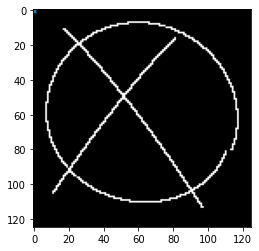

In [1083]:
xvals, yvals = create_handwritten_circle(random.normalvariate(0, math.pi), 
                                         random.normalvariate(0, 0.25), 
                                         random.normalvariate(0, 0.5))
mask_circle = calculate_mask(xvals, yvals, (125, 125))


xvals, yvals = create_handwritten_cross(0.15, 0.05)


plt.plot(xvals, yvals)


mask_cross = calculate_mask(xvals, yvals, (125, 125))

mask_circle += mask_cross
mask_circle[mask_circle > 1] = 1
show_image(mask_circle)


In [ ]:
def create_handwritten_doodle(alpha: float, beta: float, gamma: float, outlier_shape: Tuple[float, float] = (1., 1.)):
    """
    :param alpha: deviation of handle points X values
    :param beta: deviation of handle points Y values
    :param gamma: deviation of bezier control point position
    """

    def calculate_control(first_handle: Point, second_handle: Point):
        middle_x, middle_y = abs(first_handle.x - second_handle.x)/2, (abs(first_handle.y - second_handle.y)/2 + min(first_handle.y, second_handle.y))
        return random.normalvariate(middle_x, gamma), random.normalvariate(middle_y, 0) 

    lines = []
    recent_handle = Point(random.normalvariate(alpha/2, alpha/6), random.normalvariate(beta/2, beta/6))
    while recent_handle.y < outlier_shape[1] + random.normalvariate(beta/2, beta/6):
        alpha_shift, beta_shift = random.normalvariate(alpha/2, alpha/6), random.normalvariate(beta/2, beta/6)
        next_handle = Point(alpha_shift if recent_handle[0] > outlier_shape[0]/2 else outlier_shape[0]-alpha_shift, recent_handle[1] + beta_shift)
        control_point = calculate_control(recent_handle, next_handle)
        lines.append(bezier_curve([recent_handle, control_point, next_handle], 10000))
        recent_handle = next_handle

    return np.concatenate(lines, axis=1)

def rotate_doodle(image: np.array, rotation: int, scale: float):
    image_center = tuple(np.array(image.shape[1::-1])/2)
    rotated_mask_circle = cv2.getRotationMatrix2D(image_center, rotation, scale)
    return cv2.warpAffine(mask_drawings, rotated_mask_circle, mask_drawings.shape[1::-1], flags=cv2.INTER_LINEAR)

In [ ]:
xvals, yvals = create_handwritten_doodle(0.2, 0.04, 0.05)
mask_drawings = calculate_mask(xvals, yvals, (125, 125))
rotated_mask_circle = rotate_doodle(mask_drawings, 30, 1.5)

show_image(rotated_mask_circle)


In [ ]:
def create_handwritten_tick(alpha: float, beta: float, gamma: float):
    left_handle = Point(random.normalvariate(alpha/2, alpha/6), random.normalvariate(1/4, beta))
    right_handle = Point(random.normalvariate(1 - alpha/2, alpha/6), random.normalvariate(1/4, beta))          
    right_control = Point(random.normalvariate(right_handle.x - gamma/2, gamma/6), random.normalvariate(3/4, beta))
    left_control = Point(random.normalvariate(left_handle.x + gamma/2, gamma/6), random.normalvariate(3/4, beta))
    return bezier_curve([left_handle, right_control, left_control, right_handle], 1000)

In [ ]:
xvals, yvals = create_handwritten_tick(0.5, 0.15, 0.2)
mask = calculate_mask(xvals, yvals, (100, 100))
assert max(xvals) <= 1

show_image(mask)